# 3rd part: Image and texts, with EasyCLEF

In [3]:
import os
import ParserEasyClef
import ParserCACM
import modeles
import numpy as np
import query
import evaluation
import clusterings
import matplotlib.pyplot as plt
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

# Constants:

srcFolder = "easyCLEF08/"

# File that contains all documents
srcFile = "easyCLEF08_text.txt"
# File that contains all relevances for queries
relevantsFile = "easyCLEF08_gt.txt"
# File that contains all queries
qryFile = "easyCLEF08_query.txt"

easyClef_txt = os.path.join(srcFolder, srcFile)
easyClef_qry = os.path.join(srcFolder, qryFile)
easyClef_rel = os.path.join(srcFolder, relevantsFile)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import indexation 
import TextRepresenter

parser = ParserEasyClef.ParserEasyClef()
stemmer =  TextRepresenter.PorterStemmer()
idx = indexation.InMemoryIndex(easyClef_txt, 
                               parser, 
                               stemmer)
all_docs_id = idx.getDocsID()
print("All docs ID (%d):" % len(all_docs_id))
print(all_docs_id)

allQueries = {}
qp = query.QueryParserCACM(easyClef_qry, easyClef_rel)
qry = qp.nextQuery()
while qry is not None:
    allQueries[int(qry.getID())] = qry
    qry = qp.nextQuery()
print("All qry ids (%d):" % len(allQueries))
print(allQueries.keys())


All docs ID (2256):
['9019', '21324', '39527', '39628', '18887', '37325', '19287', '7133', '39059', '30893', '40655', '16709', '9968', '6946', '3414', '6912', '690', '25208', '37478', '8765', '38265', '1966', '16034', '11520', '13721', '40188', '37375', '20095', '37365', '38054', '31846', '31617', '37218', '11355', '21218', '6242', '39714', '4565', '19705', '39699', '40171', '38200', '39159', '31296', '40286', '9159', '37499', '2595', '40215', '21319', '40570', '2720', '6379', '35706', '10295', '12143', '37448', '39246', '26438', '14408', '16671', '30825', '26442', '37596', '37213', '24427', '31879', '17198', '8975', '7681', '2711', '17418', '37244', '30768', '31674', '4027', '31219', '38160', '37305', '19051', '37483', '35874', '10975', '13238', '5011', '38042', '7913', '22874', '37896', '37242', '4083', '11356', '15400', '31702', '27676', '9945', '38146', '8738', '9544', '38053', '31543', '37324', '25932', '3643', '1581', '32480', '9696', '8763', '5164', '30243', '20357', '37372', '3

## Test baseline for some queries

In [3]:
modele_vect = modeles.Vectoriel(idx, modeles.TfidfWeighter(idx))
wantedId = [5, 3]
print("Searching for query", wantedId)
for qryID in wantedId :
    qry = allQueries[qryID]
    print("Query")
    print(qry)
    qry_repr = stemmer.getTextRepresentation(qry.getText())
    dict_scores = modele_vect.getScores(qry_repr)
    list_scores = [(docId, score) for docId, score in dict_scores.items()]
    irlist = evaluation.IRList(qry, list_scores)
    eval_precAtN = evaluation.PrecisionNDocuments(irlist)
    eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
    n = 40
    print("Precision at %d docs:" % n)
    print(eval_precAtN.eval(n, verbose=True))
    print("Cluster Recall at %d docs:" % n)
    print(eval_CRAtN.eval(n, verbose=True))

    print(20 * '-')
    
print("Done.")


Searching for query [5, 3, 18, 28, 60, 16, 34, 39, 44, 10, 52, 13]
Query
Query {id=5, txt='animal swimming. Relevant images will show one or more animals (fish, birds, reptiles, etc.) swimming in a body of water. Images of people swimming in water are not relevant. Images of animals that are not swimming are not not relevant.
', relevances=[1515, 2007, 2285, 2764, 2913, 3090, 3166, 3248, 3660, 4218, 4219, 4969, 4975, 4979, 4993, 5011, 5012, 6294, 6297, 6342, 6556, 8458, 9149, 10738, 12608, 13170, 13183, 15027, 15172, 15405, 15645, 16638, 16952, 19108, 26625, 30783, 30817, 30822, 30824, 30825, 30826, 30827, 30828, 30829, 30830, 30831, 30843, 30844, 30845, 30846, 30863, 30865, 30866, 30867, 30868, 30869, 31072, 37447, 37448, 37449, 37450, 38269, 38270, 38271]}
Precision at 40 docs:
Result:  3090
Relevant, found docs = 1
Result:  15405
Relevant, found docs = 2
Result:  30828
Relevant, found docs = 3
Result:  30825
Relevant, found docs = 4
Result:  38271
Relevant, found docs = 5
Result:  3

## Test of greedy

In [4]:
alpha = 0.6
prGreedy = modeles.GreedyAlgorithm(idx, modele_vect, alpha, nDocs=200)

wantedId = [5, 3]
print("Searching for query", wantedId)
for qryID in wantedId:
    qry = allQueries[qryID]
    print("Query")
    print(qry)
    qry_repr = stemmer.getTextRepresentation(qry.getText())
    ranking = prGreedy.getRanking(qry_repr, verbose=True)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    eval_precAtN = evaluation.PrecisionNDocuments(irlist)
    eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
    n = 40
    print("Precision at %d docs:" % n)
    print(eval_precAtN.eval(n, verbose=True))
    #prec.append(eval_precAtN.eval(n, verbose=True))
    print("Cluster Recall at %d docs:" % n)
    print(eval_CRAtN.eval(n, verbose=True))
    #rec.append(eval_CRAtN.eval(n, verbose=True))

    print(20 * '-')
#PR.append(np.mean(prec))
#CR.append(np.mean(rec))


print("Done.")


Precision at 40 docs:
Result:  38117
Relevant, found docs = 1
Result:  38129
Result:  38096
Relevant, found docs = 2
Result:  4898
Result:  38118
Relevant, found docs = 3
Result:  38103
Result:  38230
Relevant, found docs = 4
Result:  38224
Relevant, found docs = 5
Result:  38225
Relevant, found docs = 6
Result:  38227
Relevant, found docs = 7
Result:  38223
Relevant, found docs = 8
Result:  22777
Result:  38226
Relevant, found docs = 9
Result:  38046
Relevant, found docs = 10
Result:  37894
Result:  4723
Result:  38038
Relevant, found docs = 11
Result:  38121
Relevant, found docs = 12
Result:  37274
Result:  13594
Result:  38271
Result:  38133
Relevant, found docs = 13
Result:  38166
Relevant, found docs = 14
Result:  38137
Result:  38161
Relevant, found docs = 15
Result:  22734
Result:  38036
Relevant, found docs = 16
Result:  38053
Relevant, found docs = 17
Result:  38054
Relevant, found docs = 18
Result:  38084
Relevant, found docs = 19
Result:  38269
Result:  38045
Relevant, found

## Test of clustering

In [5]:
kmeans = clusterings.KMeansClustering()
meanshift = clusterings.MeanShiftClustering()

prCluster = modeles.PRClustering(idx, modele_vect, meanshift, nDocs=200)

wantedId = [5, 3]
print("Searching for query", wantedId)
for qryID in wantedId:
    qry = allQueries[qryID]
    print("Query")
    print(qry)
    qry_repr = stemmer.getTextRepresentation(qry.getText())
    %time ranking = prCluster.getRanking(qry_repr, Nclusters=None, verbose=True)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    eval_precAtN = evaluation.PrecisionNDocuments(irlist)
    eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
    n = 20
    print("Precision at %d docs:" % n)
    print(eval_precAtN.eval(n, verbose=True))
    print("Cluster Recall at %d docs:" % n)
    print(eval_CRAtN.eval(n, verbose=True))

    print(20 * '-')
    
print("Done.")


Searching for query [5, 3]
Query
Query {id=5, txt='animal swimming. Relevant images will show one or more animals (fish, birds, reptiles, etc.) swimming in a body of water. Images of people swimming in water are not relevant. Images of animals that are not swimming are not not relevant.
', relevances=[1515, 2007, 2285, 2764, 2913, 3090, 3166, 3248, 3660, 4218, 4219, 4969, 4975, 4979, 4993, 5011, 5012, 6294, 6297, 6342, 6556, 8458, 9149, 10738, 12608, 13170, 13183, 15027, 15172, 15405, 15645, 16638, 16952, 19108, 26625, 30783, 30817, 30822, 30824, 30825, 30826, 30827, 30828, 30829, 30830, 30831, 30843, 30844, 30845, 30846, 30863, 30865, 30866, 30867, 30868, 30869, 31072, 37447, 37448, 37449, 37450, 38269, 38270, 38271]}

Base ranking: ['3090', '15405', '30828', '30825', '38271', '30827', '30869', '30866', '30824', '3525', '30865', '30822', '30830', '30817', '3166', '30831', '30826', '26625', '9331', '35644', '19114', '30845', '30863', '30829', '15645', '17836', '23052', '11330', '26709'


Base ranking: ['3407', '3414', '4815', '38216', '38217', '38218', '38219', '38221', '38222', '35780', '4759', '6246', '21221', '4927', '5109', '38265', '35884', '35885', '25966', '39169', '30334', '38898', '4723', '17947', '15194', '20357', '14520', '15973', '27353', '28', '19115', '11230', '4533', '19194', '4089', '30011', '19135', '21319', '4900', '21222', '39131', '4946', '23241', '15763', '30843', '20356', '2858', '4531', '4642', '37244', '37237', '37191', '11170', '24320', '4948', '22777', '4812', '19211', '10657', '4898', '10730', '10999', '37194', '23108', '37184', '40542', '27510', '39133', '15330', '6973', '37192', '38129', '17550', '3147', '31430', '16574', '27322', '40427', '40328', '31398', '37636', '35844', '36035', '39516', '10810', '40571', '31172', '40570', '19198', '31431', '40426', '40357', '16993', '1591', '27440', '38636', '16819', '37354', '20348', '20349', '35783', '31396', '39358', '9926', '23052', '27682', '19259', '32861', '39513', '39515', '39514', '13409', '

## Plot for one query:

Query:  Query {id=16, txt='people in San Francisco. Relevant images will show the Californian city of San Francisco with at least one person. Images of San Francisco without people are not relevant. Images of people not in San Francisco are not relevant.
', relevances=[38033, 38034, 38035, 38036, 38038, 38040, 38041, 38042, 38043, 38044, 38045, 38046, 38052, 38053, 38054, 38059, 38068, 38073, 38077, 38084, 38086, 38087, 38096, 38117, 38118, 38121, 38124, 38133, 38140, 38144, 38146, 38150, 38152, 38160, 38161, 38166, 38167, 38169, 38174, 38182, 38216, 38217, 38218, 38219, 38221, 38222, 38223, 38224, 38225, 38226, 38227, 38230, 38231, 38263, 38264, 38265]}


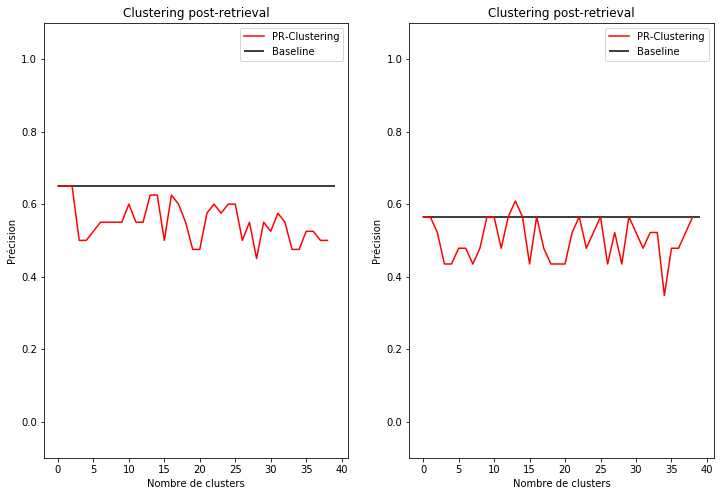

Query:  Query {id=56, txt='photos of oxidised vehicles. Relevant images will show one or more oxidised (rusty) vehicles. Images of new vehicles or vehicles with no rust are not relevant. Images of rusty objects that are not vehicles are not relevant either.
', relevances=[1581, 3513, 4406, 6379, 7536, 7816, 7951, 8070, 9529, 10195, 10583, 10636, 11491, 12559, 14767, 18518, 22684, 26944, 27108, 30382, 30893, 30894, 30895, 30896, 30898, 38739, 38740, 38935]}


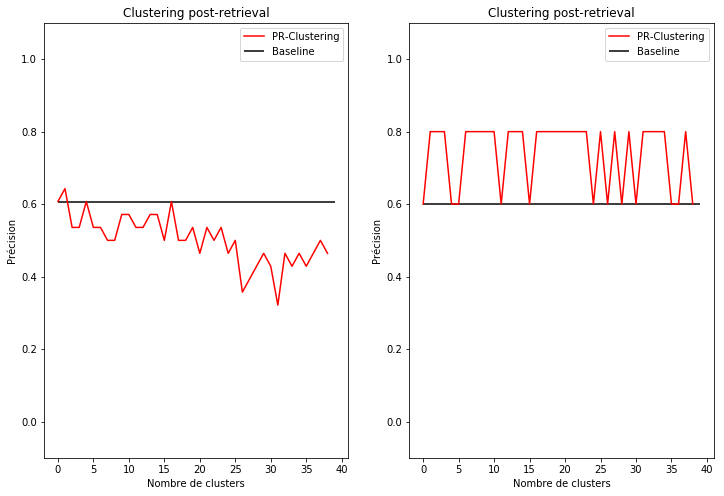

Query:  Query {id=11, txt='black and white photos of Russia. Relevant images are black and white photographs taken anywhere in Russia. Coloured images are not relevant; black and white images that were not taken in Russia are also not relevant.
', relevances=[37171, 37177, 37180, 37196, 37201, 37202, 37212, 37213, 37214, 37218, 37220, 37222, 37224, 37226, 37227, 37228, 37229, 37237, 37239, 37242, 37244, 37250, 37261, 37262, 37265, 37267, 37268, 37269, 37272, 37273, 37274, 37286, 37287, 37290, 37291, 37293, 37295, 37297, 37298, 37299, 37300, 37305, 37306, 37309, 37310, 37312, 37313, 37315, 37319, 37323, 37324, 37325, 37326, 37337, 37339, 37354, 37359, 37365, 37369, 37388, 37393, 37394, 37402, 37403, 37405]}


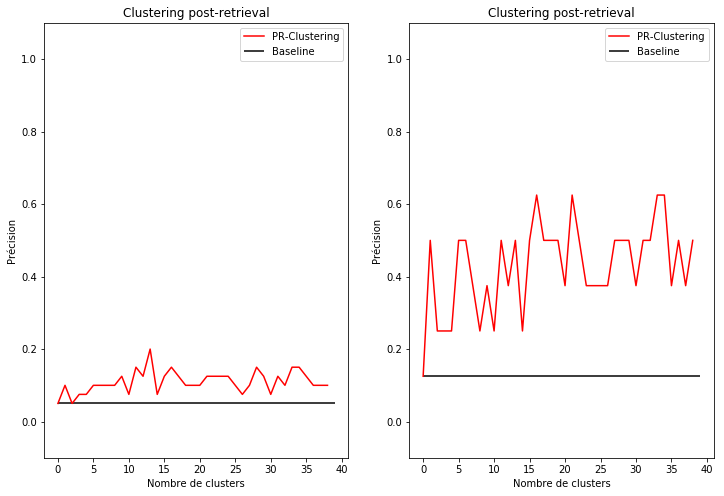

Query:  Query {id=17, txt='lighthouse at the sea. Relevant images will show lighthouses near the sea (the sea must be visible in the image). Images of lighthouses without water in the foreground or background are not relevant. Images of the sea without a lighthouse are not relevant.
', relevances=[3210, 3269, 3270, 3295, 4027, 6376, 10081, 10281, 10639, 17550, 17876, 19317, 20124, 20467, 24177, 24259, 25960, 30667, 31090, 31172, 31217, 32756, 33457, 33459, 33464, 39447, 39623]}


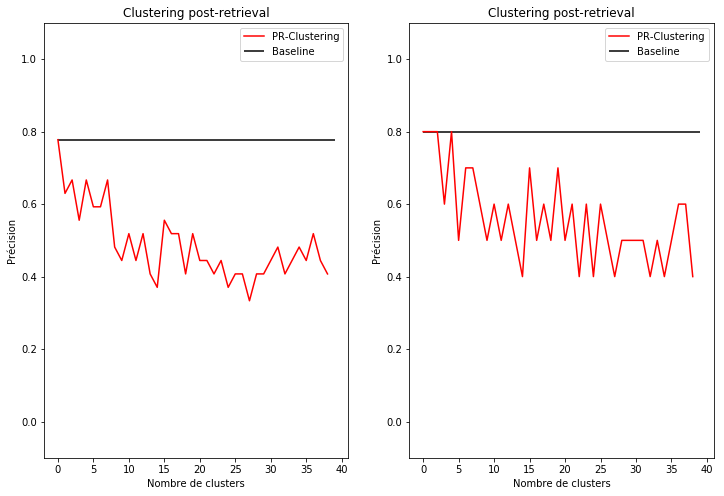

Query:  Query {id=15, txt='night shots of cathedrals. Relevant images will show churches or cathedrals at night: the building is illuminated and/or the background is black. Images of cathedrals or churches during the day are not relevant. Other night shots without cathedrals are not relevant.
', relevances=[4642, 4812, 4901, 6629, 6636, 6857, 6946, 7947, 8054, 8539, 9199, 9769, 10649, 11512, 11957, 14421, 15809, 15827, 17308, 18052, 18505, 19031, 22874, 23632, 23959]}


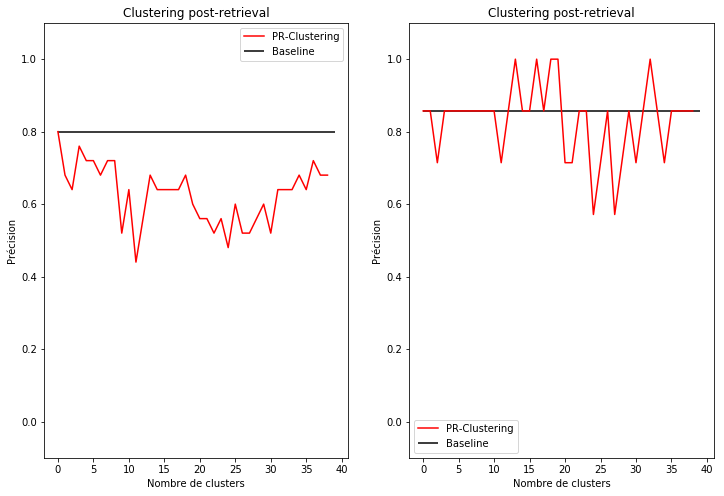

Query:  Query {id=28, txt='cathedral in Ecuador. Relevant images will show cathedrals (or churches) in Ecuador. Images with cathedrals that are not in Ecuador are not relevant. Images from Ecuador that do not show a cathedral or church are not relevant.
', relevances=[3736, 3788, 4511, 4642, 4804, 4812, 4898, 4900, 4901, 4927, 4931, 4944, 4945, 4946, 4948, 6246, 6261, 6973, 10171, 10649, 10651, 10655, 11230, 11415, 11629, 13036, 13039, 15179, 15194, 15669, 15763, 15764, 16883, 17139, 17711, 18505, 20484, 21976, 24227, 25248, 25570]}


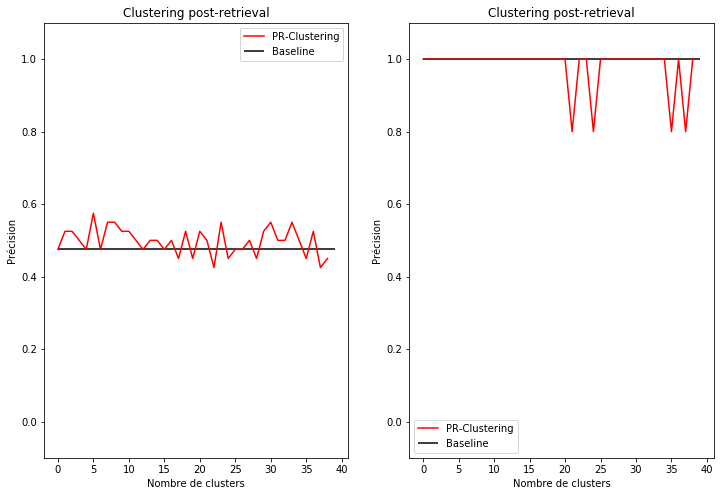

Query:  Query {id=43, txt='sunset over water. Relevant images will show the sun setting above a body of water. Images are relevant if the sun is visible in the image, and the body of water will meet the horizon where the sun is going to be setting. Images of sunsets in which the sun is not visible or will not be setting over water are not relevant.
', relevances=[1313, 1327, 1580, 1785, 2197, 2308, 2470, 2560, 3015, 3334, 3407, 3414, 3975, 4095, 4709, 4802, 5037, 6299, 6343, 7125, 8094, 8328, 9019, 9396, 9945, 10393, 10469, 10615, 10617, 11599, 12350, 16392, 16709, 18049, 18887, 18907, 19113, 19114, 22606, 22797, 22875, 23993, 25678]}


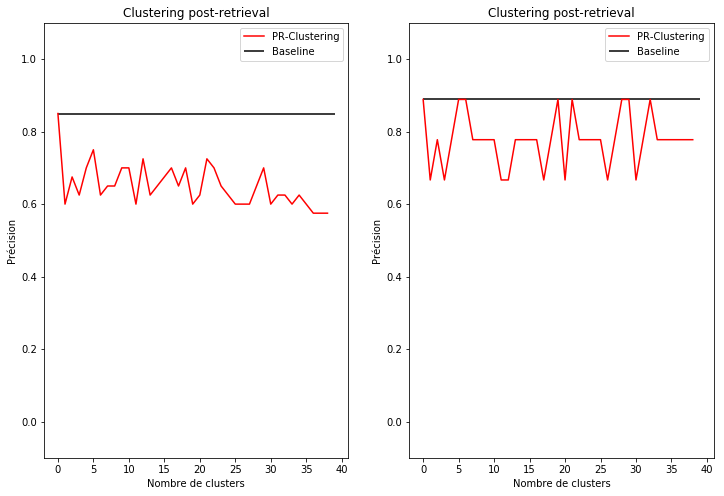

Query:  Query {id=23, txt='sport photos from California. Relevant images will depict sports activities in the US state of California. Both sporting competitions and sport for recreation, fun or as a hobby are relevant. Competitions outside of California are not relevant. Images from California that are not sport are also not relevant.
', relevances=[37411, 37416, 37417, 37420, 37477, 37478, 37483, 37488, 37489, 37493, 37496, 37497, 37498, 37499, 37500, 37501, 37502, 37504, 37506, 37507, 37508, 37509, 37510, 37511, 37513, 37515, 37516, 37518, 37519, 37520, 37521, 37527, 37528, 37529, 37530, 37531, 37532, 37533, 37534, 38004, 38005, 38006, 38007, 38008, 38009, 38011, 38012, 38013, 38014, 38015, 38016, 38019, 38020, 38021, 38024, 38027, 38028, 38029, 38030, 38096, 38103, 38129, 38192, 38193, 38194, 38197, 38198, 38199, 38200, 38223, 38224, 38225, 38226, 38227, 38230, 38241, 38242, 38244, 38245, 38246, 38247]}


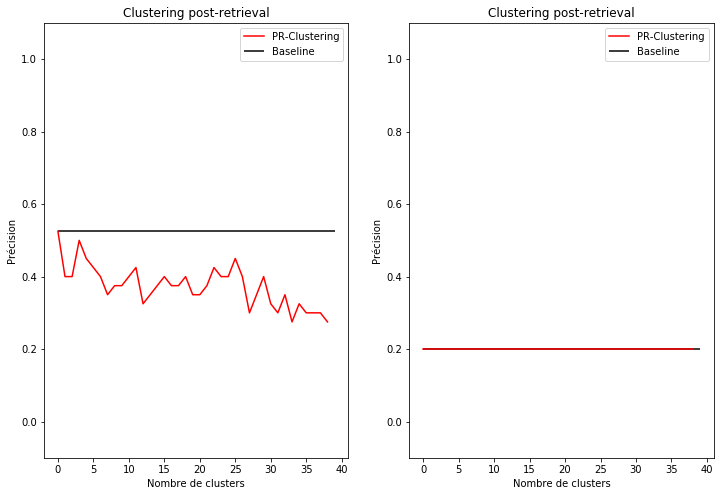

Query:  Query {id=52, txt='sports people with prizes. Relevant images will show sports people with medals, trophies, cups or other types of sports prizes. Images of sportsmen or women without a prize are not relevant.
', relevances=[31536, 31537, 31538, 31539, 31540, 31541, 31543, 31650, 31653, 31680, 31702, 32151, 32152, 32153, 32248, 32249, 32250, 32293, 32297, 32349, 32351, 32479, 32480, 32481, 37880, 37883, 37884, 37885, 40150]}


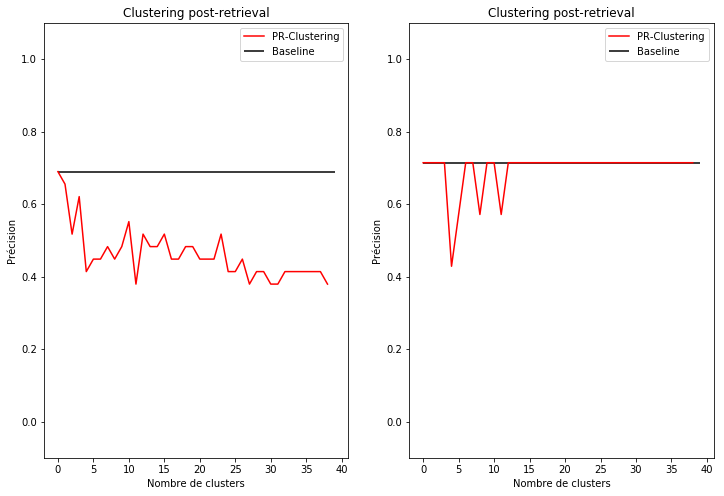

Query:  Query {id=44, txt='mountains on mainland Australia. Relevant images will show mountains on mainland Australia. Images of mountains of Australian islands (e.g. Tasmania, Kangaroo Island, etc) are not relevant. Mountains outside Australia are not relevant. Photos from Australia with no mountains are not relevant.
', relevances=[30243, 30245, 30246, 30353, 30358, 30360, 30361, 30413, 30426, 30431, 30433, 30449, 30456, 30457, 30458, 30459, 30461, 30462, 30488, 30494, 30496, 30608, 30618, 30641, 30642, 30658, 30696, 30919, 30971, 30975, 30976, 30977, 31111, 31112, 31113, 31116, 31830, 31832, 31835, 31836, 31837, 31838, 31839, 31841, 31844, 31846, 31847, 31848, 31849, 31850, 31851, 31852, 31854, 31855, 31857, 31863, 31864, 31868, 31869, 31870, 31879, 31882, 31883, 31884, 31887, 31897, 32646, 32648, 32656, 32666, 32670, 32672, 33362, 33370, 33374, 33378, 33379, 33393, 38928, 38929, 38930, 38978, 38981, 38997, 39007, 39023, 39024, 39025, 39027, 39029, 39032, 39036, 39037, 39038, 39039,

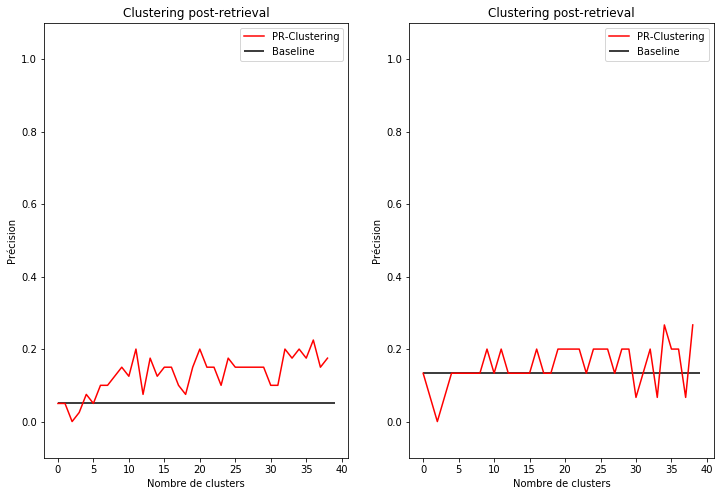

Done.


In [11]:
randQueries = np.random.choice(list(allQueries.values()), size=10, replace=False)
at = 40
nClusterRange = range(1, at)
prCluster = modeles.PRClustering(idx, baseModel=modele_vect, cluster=kmeans, nDocs=200)
for qry in randQueries:
    print("Query: ",qry)
    qry_repr = stemmer.getTextRepresentation(qry.getText())

    # Compute the baseline scores:
    dict_scores = modele_vect.getScores(qry_repr)
    list_scores = [(docId, score) for docId, score in dict_scores.items()]
    irlist = evaluation.IRList(qry, list_scores)
    eval_precAtN = evaluation.PrecisionNDocuments(irlist)
    eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
    baseline_prec = eval_precAtN.eval(at, verbose=False)
    baseline_CR   = eval_CRAtN.eval(at, verbose=False)
    #print("Baseline: prec=%f, CR=%f" % (baseline_prec, baseline_CR))

    # Compute the post-retrieval clustering:
    precisions = []
    CRs = []
    for nCluster in nClusterRange:

        ranking = prCluster.getRanking(qry_repr, Nclusters=nCluster)
        irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
        eval_precAtN = evaluation.PrecisionNDocuments(irlist)
        eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
        prec = eval_precAtN.eval(at)
        CR = eval_CRAtN.eval(at, verbose=False)
        precisions.append(prec)
        CRs.append(CR)
        #print("%d clusters: prec=%f, CR=%f" % (nCluster, prec, CR))

    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.hlines(baseline_prec, xmin=0, xmax=at-1, label="Baseline")
    plt.plot(precisions, "r", label="PR-Clustering")
    plt.legend()
    plt.title("Clustering post-retrieval")
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Précision")
    plt.ylim([-0.1, 1.1])

    plt.subplot(1,2,2)
    plt.hlines(baseline_CR, xmin=0, xmax=at-1, label="Baseline")
    plt.plot(CRs, "r", label="PR-Clustering")
    plt.legend()
    plt.title("Clustering post-retrieval")
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Précision")
    plt.ylim([-0.1, 1.1])

    plt.show()

print("Done.")

# Benchmark

In [9]:
at = 40
benchmarkQueries = np.random.choice(list(allQueries.values()), size=10, replace=False)

prCluster = modeles.PRClustering(idx, baseModel=modele_vect, cluster=kmeans, nDocs=200)
baseline_prec = []
baseline_CR = []
prCluster_prec = []
prCluster_CR = []

print("Query & Base prec. & PRC prec. & Delta  & Base CR & PRC CR & Delta")
print(70*'=')

for qry in benchmarkQueries:
    qry_repr = stemmer.getTextRepresentation(qry.getText())

    # Compute the baseline scores:
    dict_scores = modele_vect.getScores(qry_repr)
    list_scores = [(docId, score) for docId, score in dict_scores.items()]
    irlist = evaluation.IRList(qry, list_scores)
    basePrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    baseCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    baseline_prec.append(basePrec)
    baseline_CR.append(baseCR)
    
    # Compute the post-retrieval clustering:
    ranking = prCluster.getRanking(qry_repr, Nclusters=None, maxClusters=20)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    prclusterPrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    prclusterCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    prCluster_prec.append(prclusterPrec)
    prCluster_CR.append(prclusterCR)
    print("%5s &    %.2f   &   %.2f   & %6.2f &  %.2f  & %.2f  & %6.2f \\\\" % 
          (qry.getID(), basePrec, prclusterPrec, prclusterPrec-basePrec, 
                        baseCR, prclusterCR, prclusterCR-baseCR))

        
print(70*'=')
meanBasePrec = np.mean(baseline_prec)
meanBaseCR = np.mean(baseline_CR)
meanPrcPrec = np.mean(prCluster_prec)
meanPrcCR = np.mean(prCluster_CR)
print("Mean  &    %.2f   &   %.2f   & %6.2f &  %.2f  & %.2f  & %6.2f \\\\" % 
          (meanBasePrec, meanPrcPrec, meanPrcPrec-meanBasePrec,
           meanBaseCR, meanPrcCR, meanPrcCR-meanBaseCR))    
print("Done.")

Query & Base prec. & PRC prec. & Delta  & Base CR & PRC CR & Delta
   11 &    0.05   &   0.10   &   0.05 &  0.12  & 0.50  &   0.38 \\
   18 &    0.42   &   0.42   &   0.00 &  0.56  & 0.67  &   0.11 \\
   16 &    0.65   &   0.53   &  -0.12 &  0.57  & 0.39  &  -0.17 \\
   23 &    0.53   &   0.42   &  -0.10 &  0.20  & 0.20  &   0.00 \\
   48 &    0.65   &   0.62   &  -0.03 &  0.80  & 0.80  &   0.00 \\
   54 &    0.72   &   0.44   &  -0.28 &  1.00  & 0.75  &  -0.25 \\
    2 &    0.33   &   0.29   &  -0.04 &  0.60  & 0.60  &   0.00 \\
   40 &    0.42   &   0.38   &  -0.05 &  0.36  & 0.36  &   0.00 \\
   52 &    0.69   &   0.52   &  -0.17 &  0.71  & 0.71  &   0.00 \\
   49 &    1.00   &   0.93   &  -0.07 &  1.00  & 1.00  &   0.00 \\
Mean  &    0.55   &   0.46   &  -0.08 &  0.59  & 0.60  &   0.01 \\
Done.


## With MeanShift

In [13]:

at = 40

prCluster = modeles.PRClustering(idx, baseModel=modele_vect, cluster=meanshift, nDocs=300)
baseline_prec = []
baseline_CR = []
prCluster_prec = []
prCluster_CR = []

print("Query & Base prec. & PRC prec. & Delta  & Base CR & PRC CR & Delta")
print(70*'=')

for qry in benchmarkQueries:
    qry_repr = stemmer.getTextRepresentation(qry.getText())

    # Compute the baseline scores:
    dict_scores = modele_vect.getScores(qry_repr)
    list_scores = [(docId, score) for docId, score in dict_scores.items()]
    irlist = evaluation.IRList(qry, list_scores)
    basePrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    baseCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    baseline_prec.append(basePrec)
    baseline_CR.append(baseCR)
    
    # Compute the post-retrieval clustering:
    ranking = prCluster.getRanking(qry_repr, Nclusters=None, maxClusters=20)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    prclusterPrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    prclusterCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    prCluster_prec.append(prclusterPrec)
    prCluster_CR.append(prclusterCR)
    print("%5s &    %.2f   &   %.2f   & %6.2f &  %.2f  & %.2f  & %6.2f \\\\" % 
          (qry.getID(), basePrec, prclusterPrec, prclusterPrec-basePrec, 
                        baseCR, prclusterCR, prclusterCR-baseCR))

        
print(70*'=')
meanBasePrec = np.mean(baseline_prec)
meanBaseCR = np.mean(baseline_CR)
meanPrcPrec = np.mean(prCluster_prec)
meanPrcCR = np.mean(prCluster_CR)
print("Mean  &    %.2f   &   %.2f   & %6.2f &  %.2f  & %.2f  & %6.2f \\\\" % 
          (meanBasePrec, meanPrcPrec, meanPrcPrec-meanBasePrec,
           meanBaseCR, meanPrcCR, meanPrcCR-meanBaseCR))    
print("Done.")

Query & Base prec. & PRC prec. & Delta  & Base CR & PRC CR & Delta
   31 &    0.88   &   0.88   &   0.00 &  0.80  & 0.80  &   0.00 \\
   40 &    0.42   &   0.40   &  -0.02 &  0.36  & 0.45  &   0.09 \\
    2 &    0.33   &   0.33   &   0.00 &  0.60  & 0.60  &   0.00 \\
   56 &    0.61   &   0.57   &  -0.04 &  0.60  & 0.60  &   0.00 \\
   10 &    0.40   &   0.42   &   0.02 &  0.17  & 0.17  &   0.00 \\
   52 &    0.69   &   0.52   &  -0.17 &  0.71  & 0.71  &   0.00 \\
   35 &    0.93   &   0.93   &   0.00 &  0.62  & 0.62  &   0.00 \\
   12 &    0.53   &   0.47   &  -0.06 &  1.00  & 1.00  &   0.00 \\
   21 &    1.00   &   1.00   &   0.00 &  1.00  & 1.00  &   0.00 \\
   59 &    0.38   &   0.38   &   0.00 &  1.00  & 1.00  &   0.00 \\
Mean  &    0.62   &   0.59   &  -0.03 &  0.69  & 0.70  &   0.01 \\
Done.


In [24]:
alpha = 0.1

at = 40

prGreedy = modeles.GreedyAlgorithm(idx, modele_vect, alpha, nDocs=300)
baseline_prec = []
baseline_CR = []
prGreedy_prec = []
prGreedy_CR = []

print("Query & Base prec. & PRC prec. & Delta  & Base CR & PRC CR & Delta")
print(70*'=')

for qry in benchmarkQueries:
    qry_repr = stemmer.getTextRepresentation(qry.getText())

    # Compute the baseline scores:
    dict_scores = modele_vect.getScores(qry_repr)
    list_scores = [(docId, score) for docId, score in dict_scores.items()]
    irlist = evaluation.IRList(qry, list_scores)
    basePrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    baseCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    baseline_prec.append(basePrec)
    baseline_CR.append(baseCR)
    
    # Compute the post-retrieval clustering:
    ranking = prGreedy.getRanking(qry_repr, verbose=True)

    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    prclusterPrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    prclusterCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    prCluster_prec.append(prclusterPrec)
    prCluster_CR.append(prclusterCR)
    print("%5s &    %.2f   &   %.2f   & %6.2f &  %.2f  & %.2f  & %6.2f \\\\" % 
          (qry.getID(), basePrec, prclusterPrec, prclusterPrec-basePrec, 
                        baseCR, prclusterCR, prclusterCR-baseCR))

        
print(70*'=')
meanBasePrec = np.mean(baseline_prec)
meanBaseCR = np.mean(baseline_CR)
meanPrcPrec = np.mean(prCluster_prec)
meanPrcCR = np.mean(prCluster_CR)
print("Mean  &    %.2f   &   %.2f   & %6.2f &  %.2f  & %.2f  & %6.2f \\\\" % 
          (meanBasePrec, meanPrcPrec, meanPrcPrec-meanBasePrec,
           meanBaseCR, meanPrcCR, meanPrcCR-meanBaseCR))    
print("Done.")

Query & Base prec. & PRC prec. & Delta  & Base CR & PRC CR & Delta
   31 &    0.88   &   0.15   &  -0.72 &  0.80  & 0.50  &  -0.30 \\
   40 &    0.42   &   0.15   &  -0.28 &  0.36  & 0.36  &   0.00 \\
    2 &    0.33   &   0.00   &  -0.33 &  0.60  & 0.00  &  -0.60 \\


KeyboardInterrupt: 